In [ ]:
pip install tensornetwork

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import keras
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# Import tensornetwork
# import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
# tn.set_default_backend("tensorflow")

In [ ]:
batch_size = 64
num_classes = 10
epochs = 30

d_bond = 10 # for MPS

In [ ]:

class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

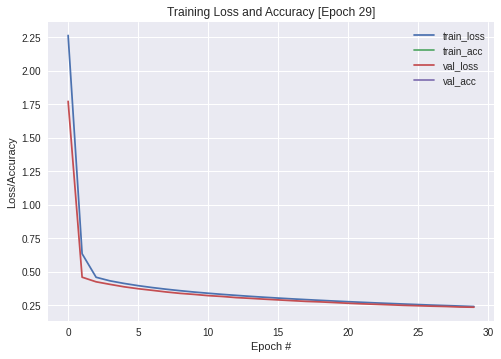

938/938 [==============================] - 12s 13ms/step - loss: 0.2422 - accuracy: 0.9291 - val_loss: 0.2371 - val_accuracy: 0.9287
Test loss: 0.23705793917179108
Test accuracy: 0.9286999702453613
CPU times: user 5min 24s, sys: 1min 23s, total: 6min 48s
Wall time: 6min 10s


In [ ]:
%%time
def preprocess_images(x):
  n_data, dim0, dim1 = tuple(x.shape)
  n_sites = dim0 * dim1
  x = x.astype(np.float32).reshape((n_data, n_sites)) / 255.0
  # x = tf.cast(tf.math.greater(x, 0.5), dtype=tf.int32)
  # return tf.keras.utils.to_categorical(x, 2)
  return np.stack([x, 1-x], axis=2)


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
# convert images to supported format
x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)


class MPSLayer(layers.Layer):

  def __init__(self, n_sites, d_bond, n_output, dtype=tf.float32):
    super(MPSLayer, self).__init__()
    if n_sites % 2:
        raise NotImplementedError("Number of sites should be even but is "
                                  "{}.".format(n_sites))

    self.n_half = n_sites // 2
    self.left = tf.Variable(self._initializer(self.n_half, 2, d_bond),
                            dtype=dtype, trainable=True)
    self.right = tf.Variable(self._initializer(self.n_half, 2, d_bond),
                             dtype=dtype, trainable=True)
    self.middle = tf.Variable(self._initializer(1, n_output, d_bond)[:,0,:,:],
                              dtype=dtype, trainable=True)

  @staticmethod
  def _initializer(n_sites, d_phys, d_bond):
    w = np.stack(d_phys * n_sites * [np.eye(d_bond)])
    w = w.reshape((d_phys, n_sites, d_bond, d_bond))
    return w + np.random.normal(0, 1e-2, size=w.shape)

  def call(self, inputs):
    left = tf.einsum("slij,bls->lbij", self.left, inputs[:, :self.n_half])
    right = tf.einsum("slij,bls->lbij", self.right, inputs[:, self.n_half:])
    left = self.reduction(left)
    right = self.reduction(right)
    return tf.einsum("bij,cjk,bki->bc", left, self.middle, right)

  @staticmethod
  def reduction(tensor):
    size = int(tensor.shape[0])
    while size > 1:
      half_size = size // 2
      nice_size = 2 * half_size
      leftover = tensor[nice_size:]
      tensor = tf.matmul(tensor[0:nice_size:2], tensor[1:nice_size:2])
      tensor = tf.concat([tensor, leftover], axis=0)
      size = half_size + int(size % 2 == 1)
    return tensor[0]


# Define model
n_sites = x_train.shape[1]
model = Sequential()
model.add(MPSLayer(n_sites=n_sites, d_bond=d_bond, n_output=num_classes))
model.add(layers.Softmax())


# Compile and run
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

his = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[plot_losses])
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(his)


In [ ]:

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mps_layer_4 (MPSLayer)       (None, 10)                157800    
_________________________________________________________________
softmax_4 (Softmax)          (None, 10)                0         
Total params: 157,800
Trainable params: 157,800
Non-trainable params: 0
_________________________________________________________________


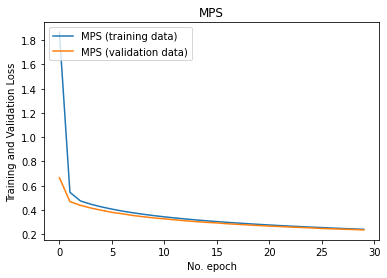

In [ ]:
import matplotlib.pyplot as plt

# Plot history: MPS
plt.plot(his.history['loss'], label='MPS (training data)')
plt.plot(his.history['val_loss'], label='MPS (validation data)')
plt.title('MPS')
plt.ylabel('Training and Validation Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
%%time
def preprocess_images(x):
  x = x.astype(np.float32) / 255.0
  return np.stack([x,1-x], axis=3)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Renormalize pixel values
# x_train = x_train[:, :, :, tf.newaxis] / 255
# x_test = x_test[:, :, :, tf.newaxis] / 255
x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Define model
input_shape = x_train.shape[1:]
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                        input_shape=input_shape))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile and run
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

his_CNN = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/30
938/938 [==============================] - 5s 5ms/step - loss: 2.2676 - accuracy: 0.1645 - val_loss: 2.2006 - val_accuracy: 0.5116
Epoch 2/30
938/938 [==============================] - 5s 5ms/step - loss: 2.1648 - accuracy: 0.3113 - val_loss: 2.0646 - val_accuracy: 0.6451
Epoch 3/30
938/938 [==============================] - 5s 5ms/step - loss: 2.0178 - accuracy: 0.4258 - val_loss: 1.8674 - val_accuracy: 0.6999
Epoch 4/30
938/938 [==============================] - 5s 5ms/step - loss: 1.8208 - accuracy: 0.5116 - val_loss: 1.6200 - val_accuracy: 0.7497
Epoch 5/30
938/938 [==============================] - 5s 5ms/step - loss: 1.5991 - accuracy: 0.5737 - val_loss: 1.3580 - val_accuracy: 0.7808
Epoch 6/30
938/938 [==============================] - 5s 5ms/step - loss: 1.3859 - accuracy: 0.6234 - val_loss: 1.1246 - val_accuracy: 0.8076
Epoch 7/30
938/938 [==============================] - 5s 5ms/step - loss: 1.2052 - accuracy: 0.6632 - val_loss: 0.9393 - val_accuracy: 0.8218
Epoch 

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        608       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)             

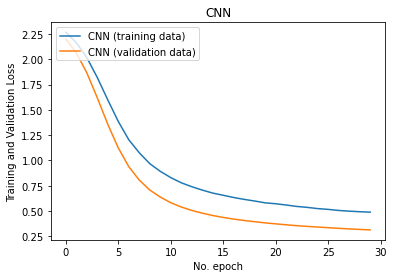

In [ ]:
import matplotlib.pyplot as plt

# Plot history: MAE
plt.plot(his_CNN.history['loss'], label='CNN (training data)')
plt.plot(his_CNN.history['val_loss'], label='CNN (validation data)')
plt.title('CNN')
plt.ylabel('Training and Validation Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()